# Cifar10 classification case study with novel class

**Goal:** In this you will investigate which advantages Bayesian NNs can offer in a classification task. You will use train data from 9 of the 10 classes in the Cifar10 dataset to fit different three probabilistic NN.
First you fit a "traditional" non-Bayesian NN and then you will fit two Bayesian NN, one via variational inference and one via dropout. You will compare the accuracy of the different NN on the 9 known classes. Further you will investigate and compare the uncertainties expressed by the NNs for both the known classes and unknown class. Finally you will use these uncertainties to detect novel classes and filter uncertain predictions.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.

**Dataset:** You work with the Cifar10 dataset. You have 60'000 32x32 pixel color images of 10 classes ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"). You will delete all iamges from the class "horse" in the training dataset to simulate a novel class. Note that we keep the class "horse" in the test dataset.

**Content:**
* Load the Cifar10 dataset
* Delete all iamges of the class "horse" from the training dataset
* Split the train dataset into a train and validation dataset (60:40 split) 
* Fit a non-Bayesian NN 
* Fit a Bayesian NN via variational inference 
* Fit a Bayesian NN via dropout 
* Compare the  of the accuracy of the models on the known classes
* Compare the  of the uncertainties of the models on the known and unknown classes
* Use the uncertainties as filter uncertain predictions

| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_04.ipynb)

In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
      !pip install tensorflow-gpu==2.0.0
      !pip install tensorflow-probability==0.8.0

    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  True


#### Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import urllib.request
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')


print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.8.0
TF  Version 2.0.0


In the next cell you disable the tensorflow eager mode. We need to do this because otherwise we would get errors for the variational inference NN and we would not be able to turn on and off the dropout in the MC dropout NN.

In [0]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

#### Loading and preparation of the dataset

Let's load the cifar 10 dataset. It is already splited into a train and test dataset. To get a feeling for the dataset, you plot a random example of each class of the trainingset.

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

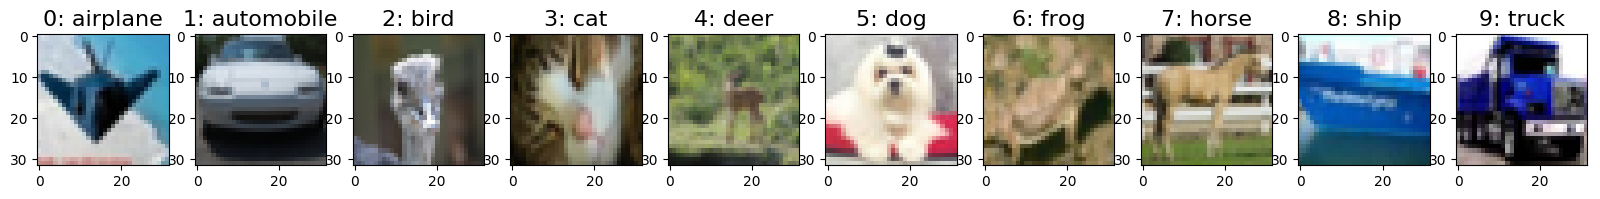

In [5]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
np.random.seed(22)
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(np.str(y_train[rmd][0][0])+ ": " +labels[i],fontsize=16)
plt.savefig("Figure_8_cifar.pdf")
#from google.colab import files
#files.download('Figure_8_cifar.pdf') 


To simualte a novel class, you will delete all images of the class "horse" from the traning dataset. Note that you do this only in the trainset, the test dataset stays the same. In the train dataset you will now have 9 classes and 5'000 images of every class, in total 45'000 images. This will be you traning dataset for the three models.   

In [6]:
y_train_no_horse=np.delete(y_train,np.where(y_train==7)[0])
x_train_no_horse=np.delete(x_train,np.where(y_train==7)[0],axis=0)
print(y_train_no_horse.shape)
print(x_train_no_horse.shape)
y_train_no_horse=np.array(pd.get_dummies(y_train_no_horse))
labels_no_horse=np.array(["airplane","automobile","bird","cat","deer","dog","frog","ship","truck"])
print(y_train_no_horse.shape)

(45000,)
(45000, 32, 32, 3)
(45000, 9)


Now you split the new training dataset without the horses into a train and validationset. You use a 60:40 ratio for the split, so you have 27'000 train images with 9 classes and 18'000 validation images with 9 classes. The test dataset has 10'000 images and 10 classes, note that we have a novel (unknown) class in the testset.

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_no_horse, y_train_no_horse, test_size=0.4, random_state=22)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(27000, 32, 32, 3)
(27000, 9)
(18000, 32, 32, 3)
(18000, 9)
(10000, 32, 32, 3)
(10000, 1)


Before training the NNs with the data, we normalize the data to be in the range between -1 and 1. 

In [0]:
x_train=((x_train/255)-0.5)*2
x_val=((x_val/255)-0.5)*2
x_test=((x_test/255)-0.5)*2

## Non-Bayesian CNN

In this section we use a CNN with two convolutional blocks, followed by maxpooling layers. You use 8 kernels with the size 3x3 in the first convolutional block and in the second block you use 16 kernels with the size 3x3. The maxpoolingsize is 2x2 pixels. After the feature extraction you use a flatten layer and do the classification with 3 fully connected layers. Because the training takes a lot of time, you will load a already trained CNN with the learning curve.

In [9]:
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras import Sequential

model = Sequential()
model.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu',input_shape=(32,32,3)))
model.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dropout((0.5)))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout((0.5)))
model.add(Dense(9, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________

In [0]:
#history=model.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=50,verbose=1)

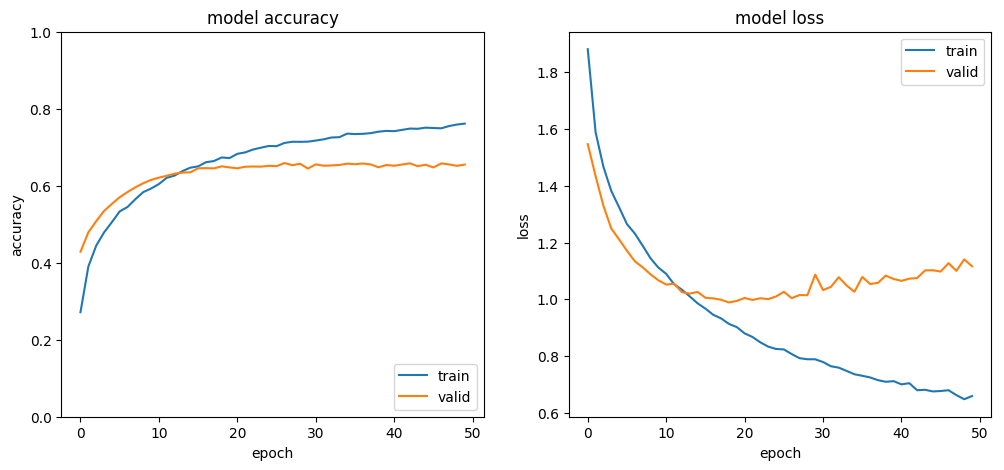

In [11]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/history_baseline_cifar10.csv", "history_baseline_cifar10.csv")
history=np.loadtxt("history_baseline_cifar10.csv",delimiter=",")
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history[:,0])
plt.plot(history[:,1])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history[:,2])
plt.plot(history[:,3])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [0]:
# load trained weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_cifar10_weights.hdf5", "model_cifar10_weights.hdf5")
model.load_weights("model_cifar10_weights.hdf5")

## Variational Inference

In [13]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x_train.shape[0] *1.0)

model_vi = Sequential()
model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn,input_shape=(32,32,3)))
model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
model_vi.add(tf.keras.layers.Flatten())
model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.DenseFlipout(9, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn))

model_vi.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_vi.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 32, 32, 8)         440       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip (None, 16, 16, 16)        2320      
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 16)          0         
_______________________________________________

In [14]:
#we get a different pred at every run!
for i in range(0,5):
  print(model_vi.predict(x_train[0:1])[0])

[0.12936798 0.119817   0.09936795 0.09424113 0.10632055 0.1210333
 0.12671873 0.08971395 0.1134194 ]
[0.14872353 0.11411501 0.09663289 0.11755907 0.06228189 0.119642
 0.11495535 0.07968321 0.146407  ]
[0.11619315 0.08348013 0.0841125  0.1913626  0.10794678 0.12191305
 0.08276793 0.07237419 0.13984965]
[0.12241374 0.13166235 0.0989796  0.11000478 0.11273888 0.09516624
 0.06983137 0.04905137 0.2101516 ]
[0.10751201 0.1225815  0.11529627 0.11332683 0.09728016 0.11057265
 0.10754127 0.06795213 0.15793717]


In [0]:
#history=model_vi.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=400,verbose=1)


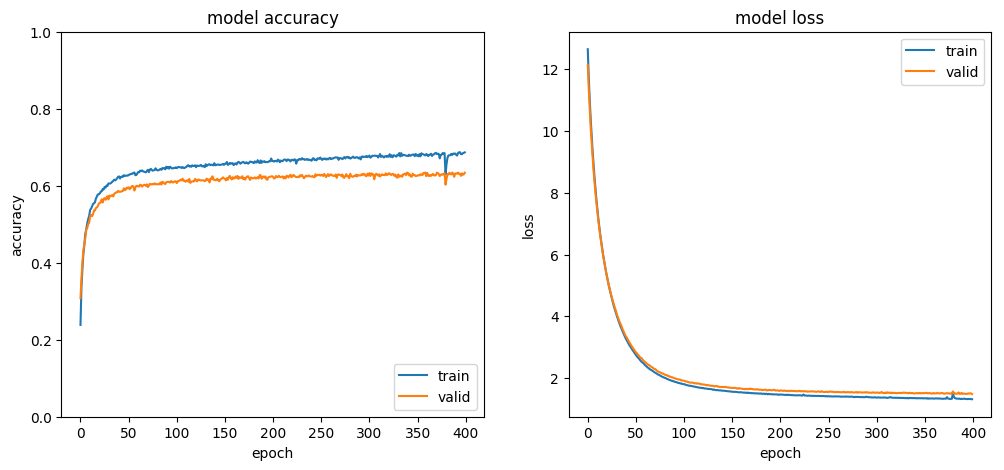

In [15]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/history_vi_cifar10.csv", "history_vi_cifar10.csv")
history=np.loadtxt("history_vi_cifar10.csv",delimiter=",")
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history[:,0])
plt.plot(history[:,1])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history[:,2])
plt.plot(history[:,3])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [0]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_vi_cifar10_weights.hdf5", "model_vi_cifar10_weights.hdf5")
model_vi.load_weights("model_vi_cifar10_weights.hdf5")

## MC Dropout

In [17]:
model_mc = Sequential()
model_mc.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu',input_shape=(32,32,3)))
model_mc.add(Dropout((0.3)))
model_mc.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(MaxPooling2D((2,2)))
model_mc.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(MaxPooling2D((2,2)))
model_mc.add(Flatten())
model_mc.add(Dense(100, activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(Dense(100, activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(Dense(9, activation = 'softmax'))

model_mc.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model_mc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 16)       

In [0]:
import tensorflow.keras.backend as K
model_mc_pred = K.function([model_mc.input, K.learning_phase()], [model_mc.output])



In [19]:
#no dropout at test time
for i in range(0,5):
  print(model_mc_pred([x_train[0:1],0])[0])

[[0.10041079 0.08799823 0.11465009 0.13328151 0.12337754 0.13507868
  0.09095283 0.10768645 0.1065639 ]]
[[0.10041079 0.08799823 0.11465009 0.13328151 0.12337754 0.13507868
  0.09095283 0.10768645 0.1065639 ]]
[[0.10041079 0.08799823 0.11465009 0.13328151 0.12337754 0.13507868
  0.09095283 0.10768645 0.1065639 ]]
[[0.10041079 0.08799823 0.11465009 0.13328151 0.12337754 0.13507868
  0.09095283 0.10768645 0.1065639 ]]
[[0.10041079 0.08799823 0.11465009 0.13328151 0.12337754 0.13507868
  0.09095283 0.10768645 0.1065639 ]]


In [20]:
#dropout at test time
for i in range(0,5):
  print(model_mc_pred([x_train[0:1],1])[0])

[[0.04421189 0.03949035 0.09237558 0.1944922  0.3156123  0.19047634
  0.04747567 0.04614235 0.02972335]]
[[0.0401734  0.01552538 0.35878816 0.11434205 0.09638878 0.13631253
  0.04559955 0.02377633 0.1690938 ]]
[[0.06427798 0.02441312 0.06175444 0.19076937 0.31922397 0.10282809
  0.04044173 0.1373211  0.05897022]]
[[0.03201118 0.01005761 0.12400385 0.11993541 0.15743797 0.03786752
  0.08490004 0.11934464 0.31444183]]
[[0.03108122 0.02536461 0.02341362 0.21751927 0.20095572 0.27613756
  0.02633035 0.11814497 0.08105268]]


In [0]:
#history=model_mc.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=400,verbose=1)

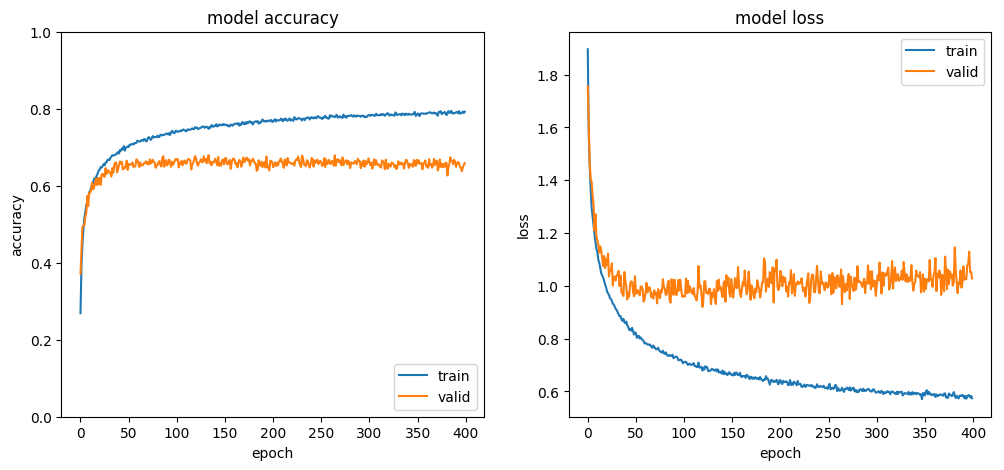

In [22]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/history_mc_cifar10.csv", "history_mc_cifar10.csv")
history=np.loadtxt("history_mc_cifar10.csv",delimiter=",")
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history[:,0])
plt.plot(history[:,1])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history[:,2])
plt.plot(history[:,3])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [0]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_mc_cifar10_weights.hdf5", "model_mc_cifar10_weights.hdf5")
model_mc.load_weights("model_mc_cifar10_weights.hdf5")

## Acc on the lables in the train set for all three models
VI and MC 50 preds und then argmax of mean

In [24]:
known_idx=np.where(y_test!=7)[0]
unknown_idx=np.where(y_test==7)[0]

print(len(known_idx))
print(len(unknown_idx))




9000
1000


In [0]:
pred=model.predict(x_test)
pred_max_p=np.max(pred,axis=1)
entropy=np.array([-np.sum( pred[i] * np.log2(pred[i] + 1E-14)) for i in range(0,len(pred))])
pred_labels=np.array([labels_no_horse[np.argmax(pred[i])] for i in range(0,len(pred))])
true_labels=np.array([labels[y_test[i][0]] for i in range(0,len(y_test))])

In [0]:
test_acc_all=np.average(true_labels==pred_labels)
test_acc_known=np.average(true_labels[known_idx]==pred_labels[known_idx])

In [42]:
# 50 pred and then mean and argmax for the val set
pred_vi=np.zeros((len(x_test),9))
pred_max_p_vi=np.zeros((len(x_test)))
pred_std_vi=np.zeros((len(x_test)))
entropy_vi = np.zeros((len(x_test)))

for i in tqdm(range(0,len(x_test))):
  multi_img=np.tile(x_test[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_vi[i]=np.mean(preds,axis=0)#mean over n runs of every proba class
  pred_max_p_vi[i]=np.argmax(np.mean(preds,axis=0))#mean over n runs of every proba class
  pred_std_vi[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy_vi[i] = -np.sum( pred_vi[i] * np.log2(pred_vi[i] + 1E-14)) #Numerical Stability
pred_labels_vi=np.array([labels_no_horse[np.argmax(pred_vi[i])] for i in range(0,len(pred_vi))])
pred_vi_mean_max_p=np.array([pred_vi[i][np.argmax(pred_vi[i])] for i in range(0,len(pred_vi))])

In [0]:
test_acc_all_vi=np.average(true_labels==pred_labels_vi)
test_acc_known_vi=np.average(true_labels[known_idx]==pred_labels_vi[known_idx])

In [44]:
pred_mc=np.zeros((len(x_test),9))
pred_max_p_mc=np.zeros((len(x_test)))
pred_std_mc=np.zeros((len(x_test)))
entropy_mc = np.zeros((len(x_test)))

for i in tqdm(range(0,len(x_test))):
  multi_img=np.tile(x_test[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred_mc[i]= np.mean(preds,axis=1)
  pred_max_p_mc[i]=np.argmax(np.mean(preds,axis=1))#mean over n runs of every proba class
  pred_std_mc[i]= np.sqrt(np.sum(np.var(preds, axis=1)))
  entropy_mc[i] = -np.sum( pred_mc[i] * np.log2(pred_mc[i] + 1E-14)) #Numerical Stability
pred_labels_mc=np.array([labels_no_horse[np.argmax(pred_mc[i])] for i in range(0,len(pred_mc))])
pred_mc_mean_max_p=np.array([pred_mc[i][np.argmax(pred_mc[i])] for i in range(0,len(pred_mc))])

In [0]:
test_acc_all_mc=np.average(true_labels==pred_labels_mc)
test_acc_known_mc=np.average(true_labels[known_idx]==pred_labels_mc[known_idx])

In [65]:
import pandas as pd
pd.DataFrame(np.array([[test_acc_known,test_acc_known_vi,test_acc_known_mc],[test_acc_all,test_acc_all_vi,test_acc_all_mc]]), index=['test acc on known labels','test acc on all labels'],columns=['Non-Bayesian','VI','MC'])

,Non-Bayesian,VI,MC
test acc on known labels,0.649444,0.670111,0.703667
test acc on all labels,0.584500,0.603100,0.633300


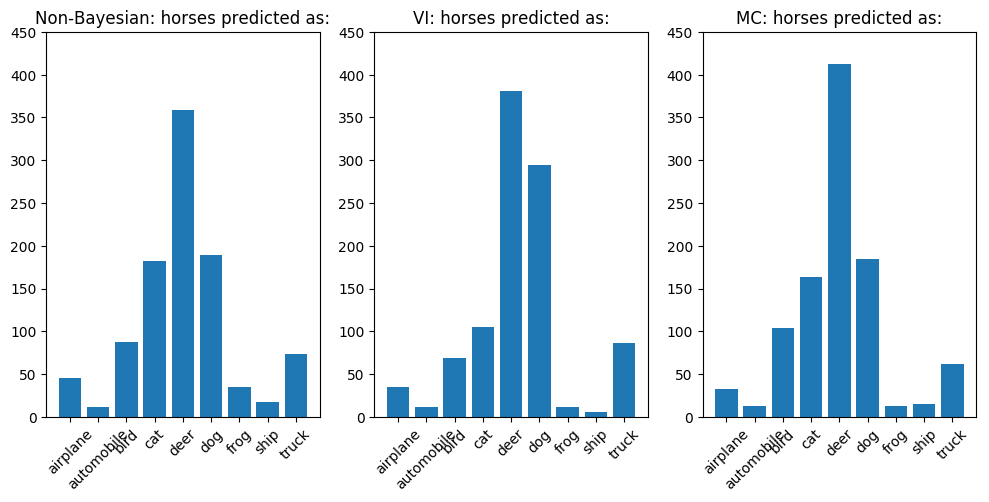

In [66]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.bar(np.unique(pred_labels[unknown_idx],return_counts=True)[0],np.unique(pred_labels[unknown_idx],return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("Non-Bayesian: horses predicted as:")
plt.ylim([0,450])

plt.subplot(1,3,2)
plt.bar(np.unique(pred_labels_vi[unknown_idx],return_counts=True)[0],np.unique(pred_labels_vi[unknown_idx],return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("VI: horses predicted as:")
plt.ylim([0,450])

plt.subplot(1,3,3)
plt.bar(np.unique(pred_labels_mc[unknown_idx],return_counts=True)[0],np.unique(pred_labels_mc[unknown_idx],return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("MC: horses predicted as:")
plt.ylim([0,450])

plt.show()

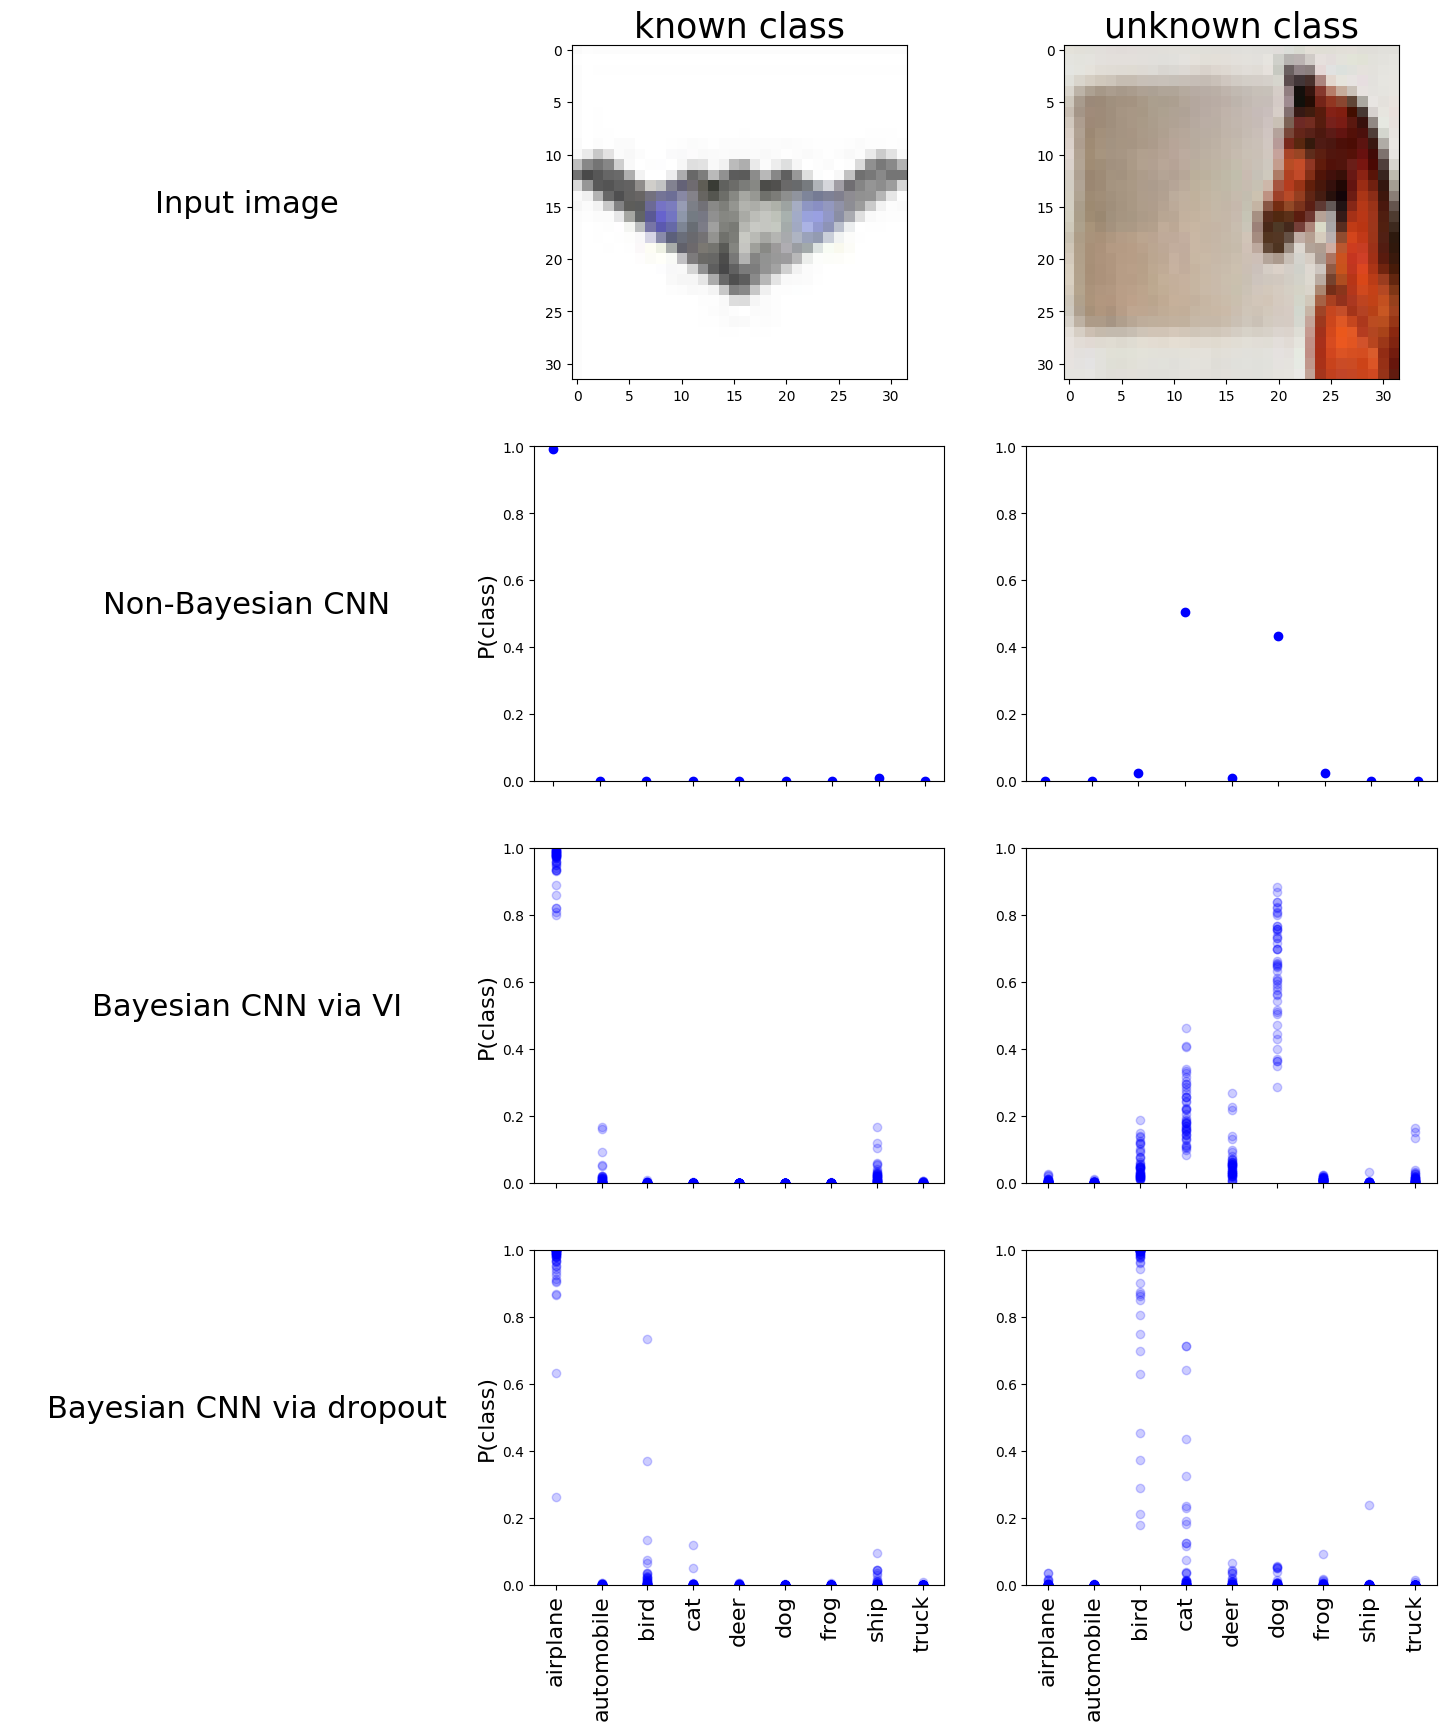

In [64]:
x_test_known = x_test[known_idx]
y_test_known = y_test[known_idx]

x_test_unknown = x_test[unknown_idx]
y_test_unknown = y_test[unknown_idx]

np.random.seed(7681)
random_sample_known=np.random.choice(range(0,len(x_test_known)),1)
np.random.seed(2384)
random_sample_unknown=np.random.choice(range(0,len(x_test_unknown)),1)

plt.figure(figsize=(18,20))
plt.subplot(4,3,1)
plt.axis('off')
plt.text(0.5,0.5, "Input image",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,2)
plt.imshow(np.squeeze(np.array(((((x_test_known[random_sample_known])/2)+0.5)*255),dtype="uint8")))
plt.title("known class",fontsize=25)
plt.subplot(4,3,3)
plt.imshow(np.squeeze(np.array(((((x_test_unknown[random_sample_unknown])/2)+0.5)*255),dtype="uint8")))
plt.title("unknown class",fontsize=25)

plt.subplot(4,3,4)
plt.axis('off')
plt.text(0.5,0.5, "Non-Bayesian CNN",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,5)
plt.scatter(range(0,9),model.predict(x_test_known[random_sample_known]),c="blue")
plt.ylabel("P(class)",fontsize=16)
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])
plt.subplot(4,3,6)
plt.scatter(range(0,9),model.predict(x_test_unknown[random_sample_unknown]),c="blue")
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])

plt.subplot(4,3,7)
plt.axis('off')
plt.text(0.5,0.5, "Bayesian CNN via VI",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,8)
for i in range(0,50):
  plt.scatter(range(0,9),model_vi.predict(x_test_known[random_sample_known]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)
plt.subplot(4,3,9)
for i in range(0,50):
  plt.scatter(range(0,9),model_vi.predict(x_test_unknown[random_sample_unknown]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])

plt.subplot(4,3,10)
plt.axis('off')
plt.text(0.5,0.5, "Bayesian CNN via dropout",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,11)
for i in range(0,50):
  plt.scatter(range(0,9),model_mc_pred([x_test_known[random_sample_known],1]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)
plt.subplot(4,3,12)
for i in range(0,50):
  plt.scatter(range(0,9),model_mc_pred([x_test_unknown[random_sample_unknown],1]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])
#plt.show()
plt.savefig("8.good2.pdf")
from google.colab import files
files.download('8.good2.pdf') 

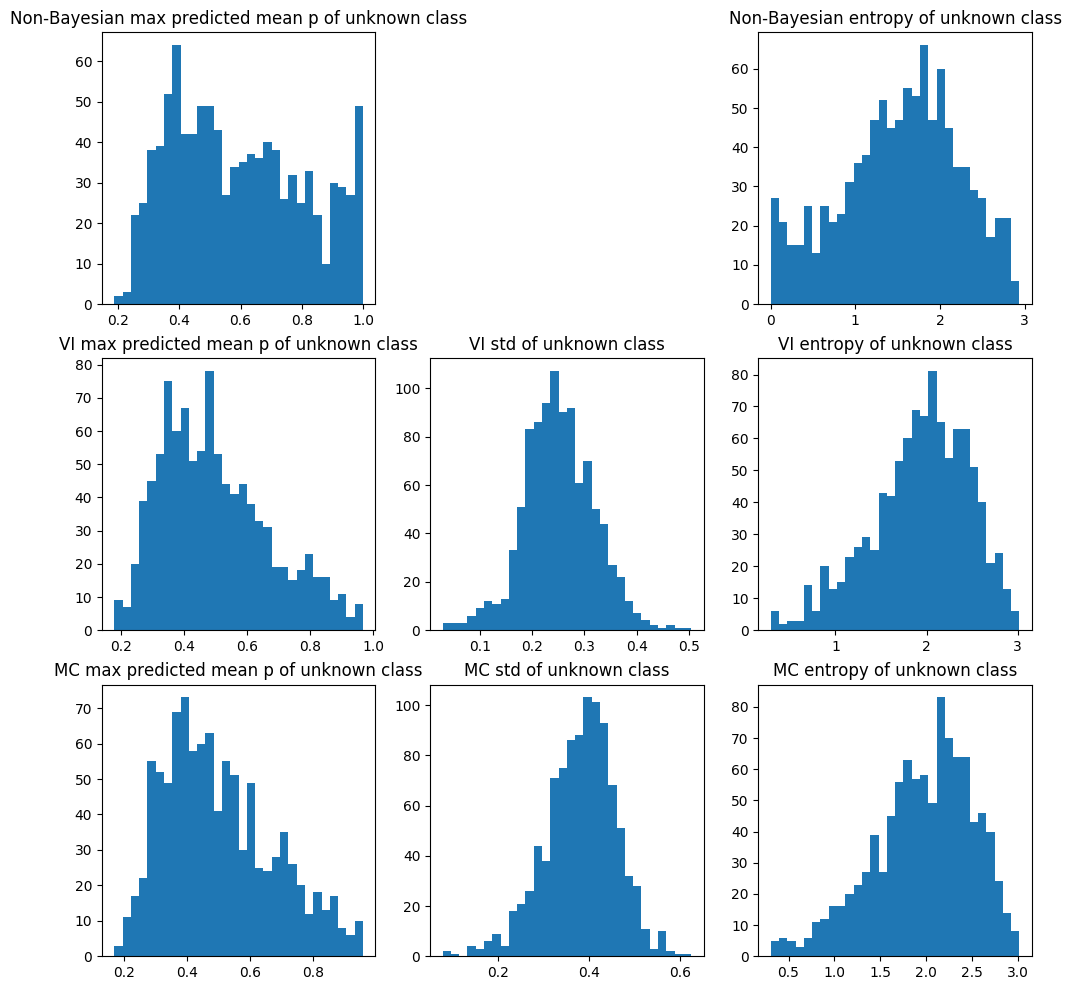

In [67]:

## look at the means sd and entropy of the true horses of the testset,
## here we want to see a hight uncertainty

plt.figure(figsize=(12,12))
plt.subplot(3,3,1)
plt.hist(pred_max_p[unknown_idx],bins=30)
plt.title("Non-Bayesian max predicted mean p of unknown class")
plt.subplot(3,3,2)
plt.axis("off")
plt.subplot(3,3,3)
plt.hist(entropy[unknown_idx],bins=30)
plt.title("Non-Bayesian entropy of unknown class")

plt.subplot(3,3,4)
plt.hist(pred_vi_mean_max_p[unknown_idx],bins=30)
plt.title("VI max predicted mean p of unknown class")
plt.subplot(3,3,5)
plt.hist(pred_std_vi[unknown_idx],bins=30)
plt.title("VI std of unknown class")
plt.subplot(3,3,6)
plt.hist(entropy_vi[unknown_idx],bins=30)
plt.title("VI entropy of unknown class")

plt.subplot(3,3,7)
plt.hist(pred_mc_mean_max_p[unknown_idx],bins=30)
plt.title("MC max predicted mean p of unknown class")
plt.subplot(3,3,8)
plt.hist(pred_std_mc[unknown_idx],bins=30)
plt.title("MC std of unknown class")
plt.subplot(3,3,9)
plt.hist(entropy_mc[unknown_idx],bins=30)
plt.title("MC entropy of unknown class")
plt.show()


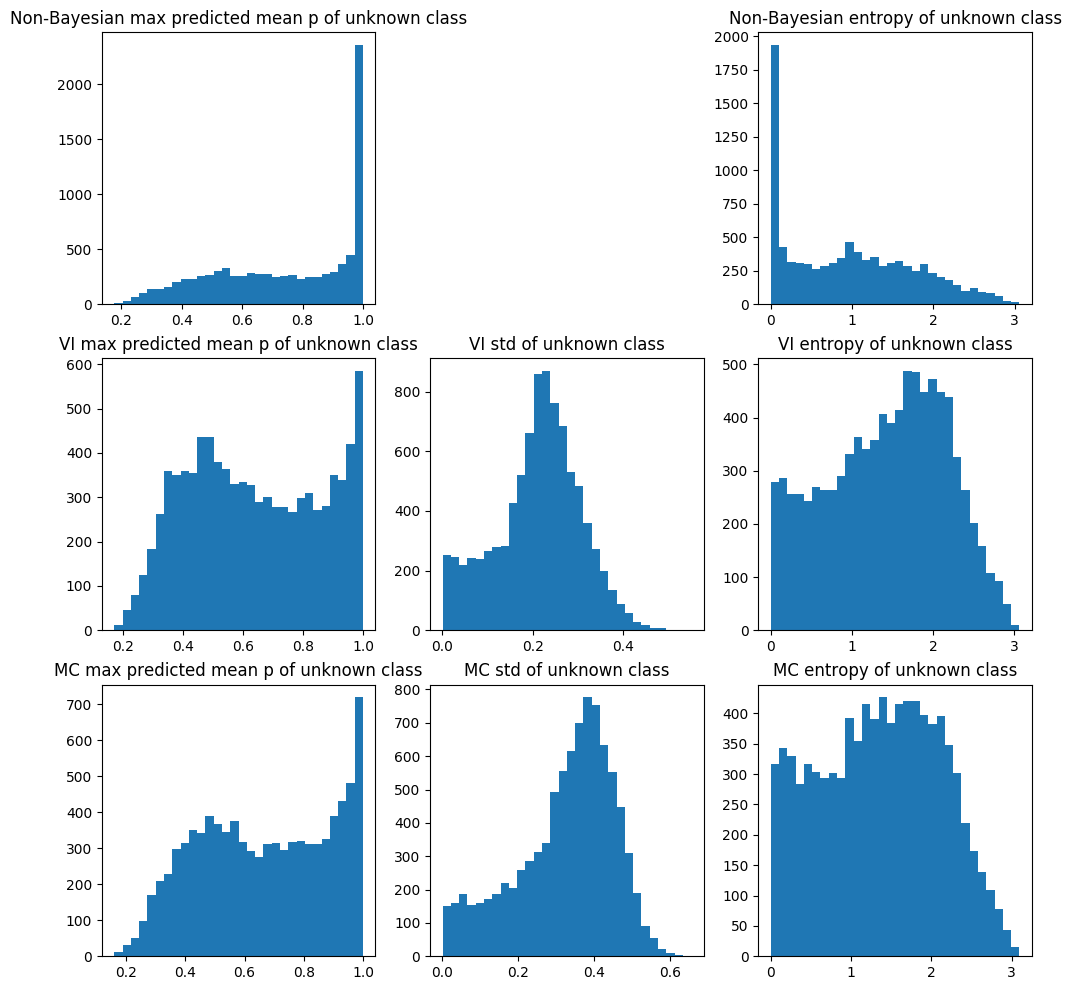

In [68]:

## look at the means sd and entropy of the true horses of the testset,
## here we want to see a hight uncertainty

plt.figure(figsize=(12,12))
plt.subplot(3,3,1)
plt.hist(pred_max_p[known_idx],bins=30)
plt.title("Non-Bayesian max predicted mean p of unknown class")
plt.subplot(3,3,2)
plt.axis("off")
plt.subplot(3,3,3)
plt.hist(entropy[known_idx],bins=30)
plt.title("Non-Bayesian entropy of unknown class")

plt.subplot(3,3,4)
plt.hist(pred_vi_mean_max_p[known_idx],bins=30)
plt.title("VI max predicted mean p of unknown class")
plt.subplot(3,3,5)
plt.hist(pred_std_vi[known_idx],bins=30)
plt.title("VI std of unknown class")
plt.subplot(3,3,6)
plt.hist(entropy_vi[known_idx],bins=30)
plt.title("VI entropy of unknown class")

plt.subplot(3,3,7)
plt.hist(pred_mc_mean_max_p[known_idx],bins=30)
plt.title("MC max predicted mean p of unknown class")
plt.subplot(3,3,8)
plt.hist(pred_std_mc[known_idx],bins=30)
plt.title("MC std of unknown class")
plt.subplot(3,3,9)
plt.hist(entropy_mc[known_idx],bins=30)
plt.title("MC entropy of unknown class")
plt.show()


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MessageError: ignored

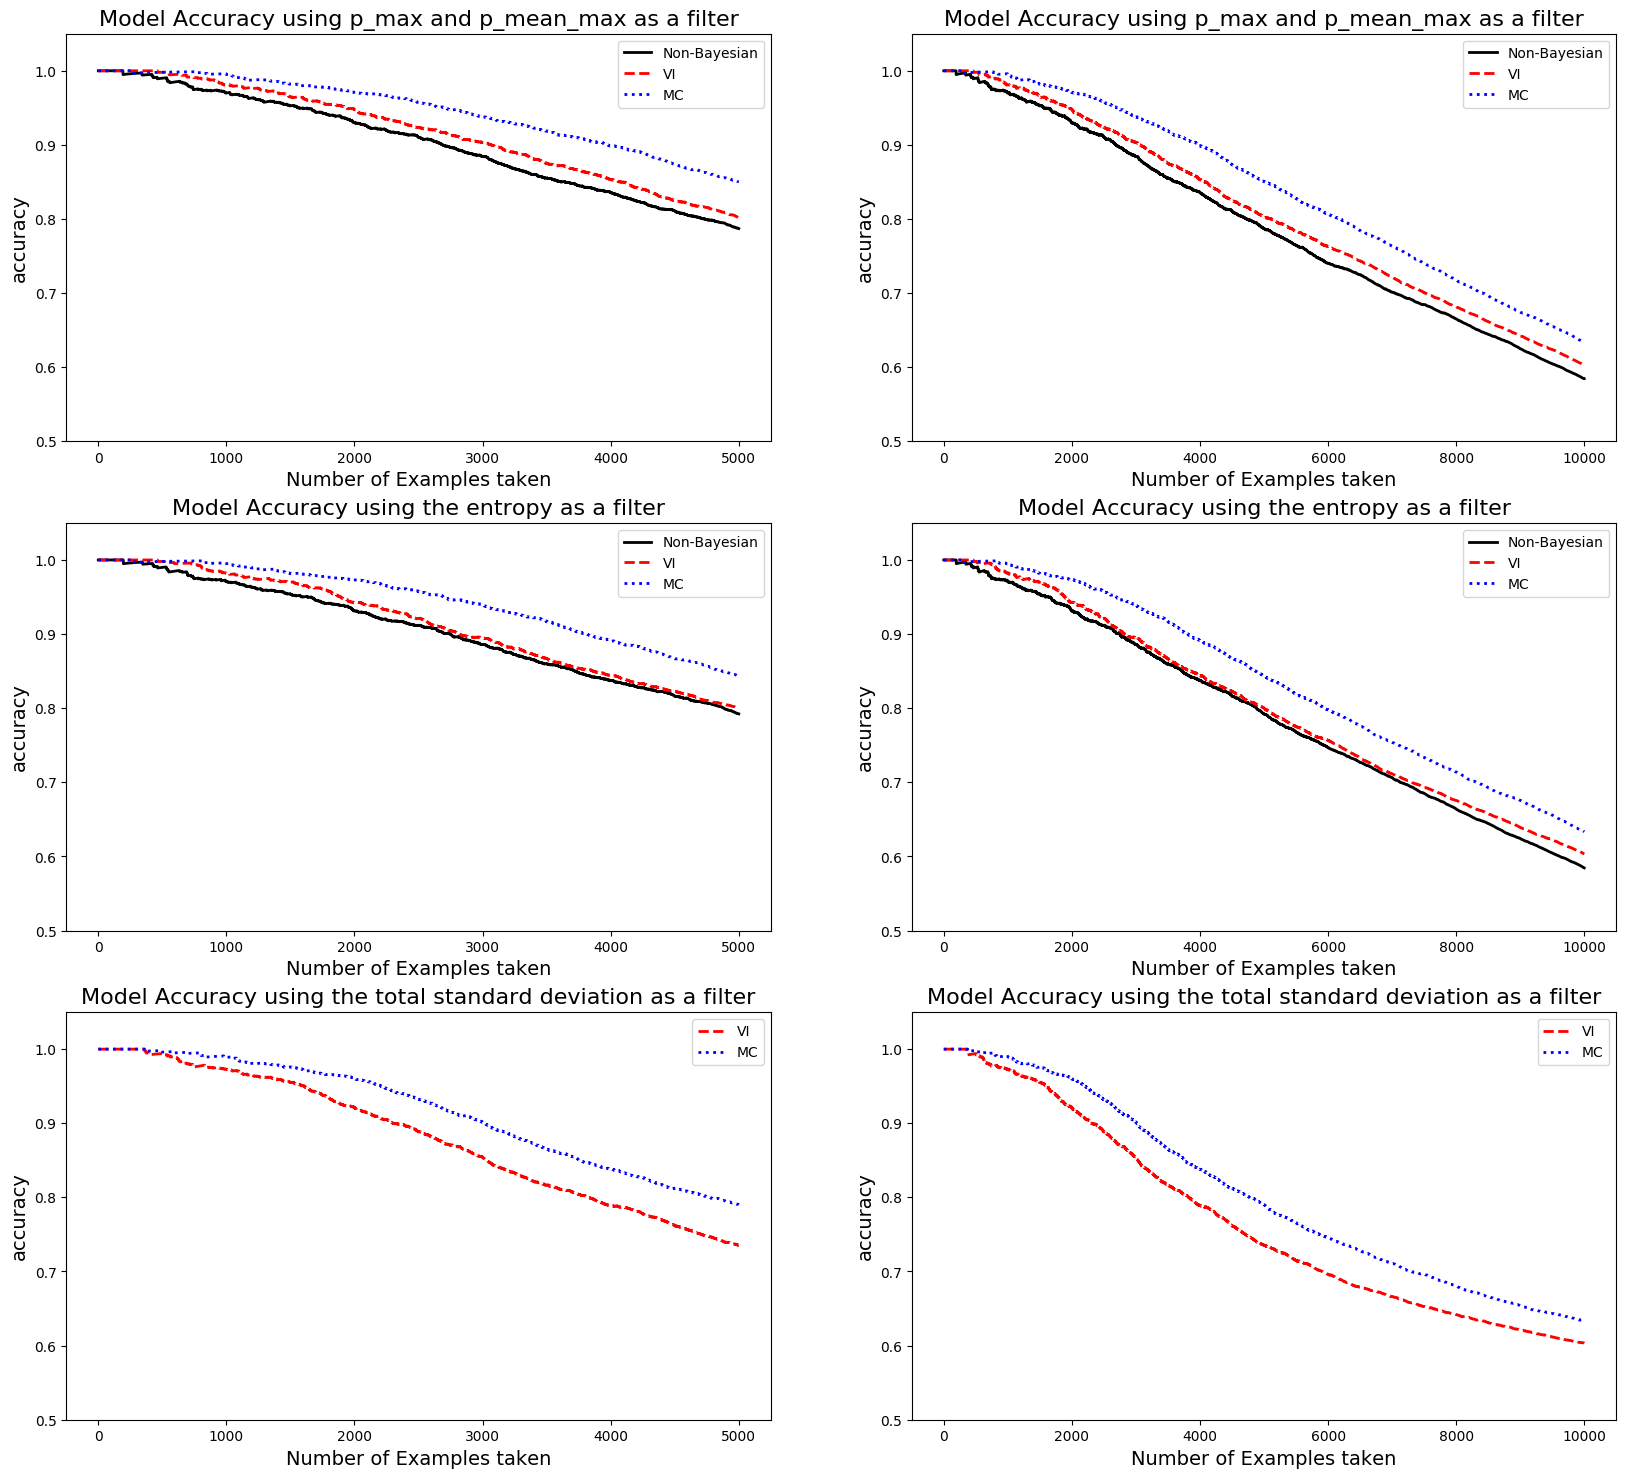

In [71]:
plt.figure(figsize=(20,18))
plt.subplot(3,2,1)
nr_of_best=5000
certainty_idx = np.argsort(pred_max_p.reshape(len(pred_max_p)))
certainty_idx = certainty_idx[::-1]#reverse
acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  acc_nbest[j]=np.average(pred_labels[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])

plt.plot(acc_nbest,c="black",linewidth=2)
plt.ylim([0.5,1.05])
plt.title('Model Accuracy using p_max and p_mean_max as a filter',fontsize=16)
plt.ylabel('accuracy',fontsize=14)
plt.xlabel('Number of Examples taken',fontsize=14)

certainty_idx = np.argsort(pred_vi_mean_max_p.reshape(len(pred_vi_mean_max_p)))
certainty_idx = certainty_idx[::-1]#reverse
acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  acc_nbest[j]=np.average(pred_labels_vi[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])
plt.plot(acc_nbest,c="red",linestyle="dashed",linewidth=2)

certainty_idx = np.argsort(pred_mc_mean_max_p.reshape(len(pred_mc_mean_max_p)))
certainty_idx = certainty_idx[::-1]#reverse
acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  acc_nbest[j]=np.average(pred_labels_mc[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])
plt.plot(acc_nbest,c="blue",linestyle="dotted",linewidth=2)
plt.legend(['Non-Bayesian', 'VI',"MC"], loc='upper right')

plt.subplot(3,2,2)
nr_of_best=10000
certainty_idx = np.argsort(pred_max_p.reshape(len(pred_max_p)))
certainty_idx = certainty_idx[::-1]#reverse
acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  acc_nbest[j]=np.average(pred_labels[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])

plt.plot(acc_nbest,c="black",linewidth=2)
plt.ylim([0.5,1.05])
plt.title('Model Accuracy using p_max and p_mean_max as a filter',fontsize=16)
plt.ylabel('accuracy',fontsize=14)
plt.xlabel('Number of Examples taken',fontsize=14)

certainty_idx = np.argsort(pred_vi_mean_max_p.reshape(len(pred_vi_mean_max_p)))
certainty_idx = certainty_idx[::-1]#reverse
acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  acc_nbest[j]=np.average(pred_labels_vi[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])
plt.plot(acc_nbest,c="red",linestyle="dashed",linewidth=2)

certainty_idx = np.argsort(pred_mc_mean_max_p.reshape(len(pred_mc_mean_max_p)))
certainty_idx = certainty_idx[::-1]#reverse
acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  acc_nbest[j]=np.average(pred_labels_mc[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])
plt.plot(acc_nbest,c="blue",linestyle="dotted",linewidth=2)
plt.legend(['Non-Bayesian', 'VI',"MC"], loc='upper right')

plt.subplot(3,2,3)
nr_of_best=5000
certainty_idx = np.argsort(entropy.reshape(len(pred_max_p)))
acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  acc_nbest[j]=np.average(pred_labels[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])

plt.plot(acc_nbest,c="black",linewidth=2)
plt.ylim([0.5,1.05])
plt.title('Model Accuracy using the entropy as a filter',fontsize=16)
plt.ylabel('accuracy',fontsize=14)
plt.xlabel('Number of Examples taken',fontsize=14)

certainty_idx = np.argsort(entropy_vi.reshape(len(entropy_vi)))
acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  acc_nbest[j]=np.average(pred_labels_vi[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])
plt.plot(acc_nbest,c="red",linestyle="dashed",linewidth=2)

certainty_idx = np.argsort(entropy_mc.reshape(len(entropy_mc)))
acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  acc_nbest[j]=np.average(pred_labels_mc[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])
plt.plot(acc_nbest,c="blue",linestyle="dotted",linewidth=2)
plt.legend(['Non-Bayesian', 'VI',"MC"], loc='upper right')

plt.subplot(3,2,4)
nr_of_best=10000
certainty_idx = np.argsort(entropy.reshape(len(pred_max_p)))
acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  acc_nbest[j]=np.average(pred_labels[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])

plt.plot(acc_nbest,c="black",linewidth=2)
plt.ylim([0.5,1.05])
plt.title('Model Accuracy using the entropy as a filter',fontsize=16)
plt.ylabel('accuracy',fontsize=14)
plt.xlabel('Number of Examples taken',fontsize=14)

certainty_idx = np.argsort(entropy_vi.reshape(len(entropy_vi)))
acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  acc_nbest[j]=np.average(pred_labels_vi[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])
plt.plot(acc_nbest,c="red",linestyle="dashed",linewidth=2)

certainty_idx = np.argsort(entropy_mc.reshape(len(entropy_mc)))
acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  acc_nbest[j]=np.average(pred_labels_mc[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])
plt.plot(acc_nbest,c="blue",linestyle="dotted",linewidth=2)
plt.legend(['Non-Bayesian', 'VI',"MC"], loc='upper right')

plt.subplot(3,2,5)
nr_of_best=5000

certainty_idx = np.argsort(pred_std_vi.reshape(len(pred_std_vi)))
acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  acc_nbest[j]=np.average(pred_labels_vi[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])
plt.plot(acc_nbest,c="red",linestyle="dashed",linewidth=2)
plt.ylim([0.5,1.05])
plt.title('Model Accuracy using the total standard deviation as a filter',fontsize=16)
plt.ylabel('accuracy',fontsize=14)
plt.xlabel('Number of Examples taken',fontsize=14)


certainty_idx = np.argsort(pred_std_mc.reshape(len(pred_std_mc)))
acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  acc_nbest[j]=np.average(pred_labels_mc[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])
plt.plot(acc_nbest,c="blue",linestyle="dotted",linewidth=2)
plt.legend(['VI',"MC"], loc='upper right')


plt.subplot(3,2,6)
nr_of_best=10000

certainty_idx = np.argsort(pred_std_vi.reshape(len(pred_std_vi)))
acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  acc_nbest[j]=np.average(pred_labels_vi[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])
plt.plot(acc_nbest,c="red",linestyle="dashed",linewidth=2)
plt.ylim([0.5,1.05])
plt.title('Model Accuracy using the total standard deviation as a filter',fontsize=16)
plt.ylabel('accuracy',fontsize=14)
plt.xlabel('Number of Examples taken',fontsize=14)


certainty_idx = np.argsort(pred_std_mc.reshape(len(pred_std_mc)))
acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  acc_nbest[j]=np.average(pred_labels_mc[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])
plt.plot(acc_nbest,c="blue",linestyle="dotted",linewidth=2)
plt.legend(['VI',"MC"], loc='upper right')
#plt.show()
plt.savefig("8.filter.pdf")
from google.colab import files
files.download('8.filter.pdf')

In [0]:
files.download('8.filter.pdf')

In [0]:
from google.colab import files
files.download('Figure_8_filter_vi_mc_with_sd.pdf')


In [0]:
from google.colab import files
files.download('Figure_8_filter_vi_mc_with_entropy.pdf')


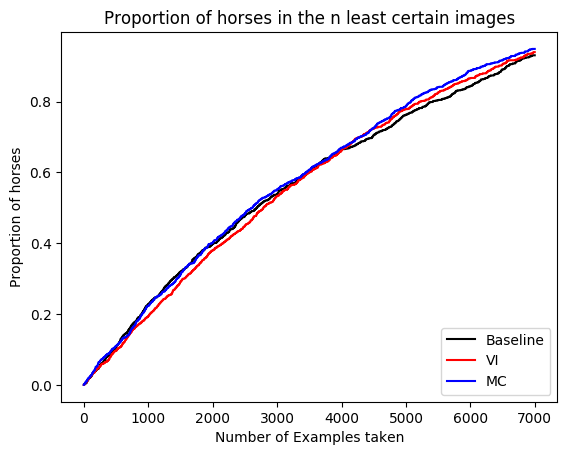

In [0]:

#what is the proportion of horses if we take the 7000 least certain images

nr_of_samples=7000

pred=model.predict(x_test)
pred=np.max(pred,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))


proportion_of_horses = np.zeros((nr_of_samples))
for j in (range(1,nr_of_samples)):
  proportion_of_horses[j]=np.sum(y_test[certainty_idx[0:j]]==7)/1000
  #
plt.plot(proportion_of_horses,c="black")
plt.title('Proportion of horses in the n least certain images')
plt.ylabel('Proportion of horses')
plt.xlabel('Number of Examples taken')


SET=x_test
pred=np.zeros((len(SET),1))
pred_means=np.zeros((len(SET),9))

for i in (range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_means[i]= np.mean(preds,axis=0)
  pred[i]=np.argmax(np.mean(preds,axis=0))
  pred_std[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy[i] = -np.sum( pred_means[i] * np.log2(pred_means[i] + 1E-14)) #Numerical Stability

pred=np.max(pred_means,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))


proportion_of_horses = np.zeros((nr_of_samples))
for j in (range(1,nr_of_samples)):
  proportion_of_horses[j]=np.sum(y_test[certainty_idx[0:j]]==7)/1000
plt.plot(proportion_of_horses,c="red")


SET=x_test
pred=np.zeros((len(SET),1))
pred_means=np.zeros((len(SET),9))

for i in (range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred_means[i]= np.mean(preds,axis=1)

pred=np.max(pred_means,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))


proportion_of_horses = np.zeros((nr_of_samples))
for j in (range(1,nr_of_samples)):
  proportion_of_horses[j]=np.sum(y_test[certainty_idx[0:j]]==7)/1000
  
plt.plot(proportion_of_horses,c="blue")
plt.legend(['Baseline', 'VI',"MC"], loc='lower right')
plt.show()







### Use the entropy and the total standart deviation as a filter?

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  


*Exercise 1: Change the code for the filtering and use the predicted entropy and the standart deviation as a filter. Note that a high value for the entropy and the standart deviation means the prediction is uncertain. Which model has the best accuracy if we take the best 3000 predictions?*